In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [1727]:
class RediCell:
    
    def __init__(self, sides=None, spacing=None, t_step=None, molecule_types=None, wall=True):
        # sides in number of voxels
        # spacing in m
        # "wall" adds one extra cell each direction, set as barrier
        self.spacing = spacing
        # Should be a list of Molecule instances
        self.molecule_types = molecule_types
        self.molecule_names = [mol.molecule_name for mol in self.molecule_types]
        self.num_types = len(self.molecule_types)
        self.mol_to_id = {mol.molecule_name: idx for idx, mol in enumerate(self.molecule_types)}
        self.id_to_mol = {idx: mol.molecule_name for idx, mol in enumerate(self.molecule_types)}
        self.wall = wall
        self.initialized = False
        self.voxel_matrix = []
        assert len(sides) > 0 and len(sides) < 4
        self.ndim = len(sides)
        self.sides = np.array(sides) # Should be [32, 32] or [32, 32, 32]
        
        if self.wall:
            self.true_sides = self.sides + 2
        else:
            self.true_sides = self.sides

        
            
        self.t_step = t_step
        self.t_trace = []
        self.conc_trace = []
        self.diffusion_vector = None
        self.reagent_vector_list = []
        self.reaction_vector_list = []
        self.reaction_coefficients = []
        self.fig = None
        self.cumulative_t = 0
        self.reaction_set = None
        self.num_reaction = 0
    
        self.side_coord = [np.linspace(0, side * a.spacing, side+1) for side in a.true_sides]
        self.mesh = np.meshgrid(*side_coord)
    
    def partition(self):
        # m, x, y matrix
        self.voxel_matrix = np.zeros((self.num_types, *self.true_sides))

        self.construct_possible_actions()
        print(f'Diffusion vector is {self.diffusion_vector}')
        
        self.diffusion_matrix = np.tile(np.expand_dims(self.diffusion_vector, tuple(range(1, self.ndim+1))), 
                                                   (1, *self.voxel_matrix.shape[1:]))
        if self.reaction_set is not None:
            # self.reagent_matrix_list = [np.tile(np.expand_dims(x, tuple(range(1, self.ndim+1))), 
            #                                            (1, *self.voxel_matrix.shape[1:])) 
            #                              for x in self.reagent_vector_list]

            self.reaction_matrix_list = [np.tile(np.expand_dims(x, tuple(range(1, self.ndim+1))), 
                                                       (1, *self.voxel_matrix.shape[1:])) 
                                         for x in self.reaction_vector_list]

        if self.wall:
            self.set_border_wall()
        #self.edit_action_vector()

    def set_border_wall(self): 
        self.not_barrier_matrix = np.ones(self.true_sides)
        if self.ndim >= 1:
            self.not_barrier_matrix[0] = 0
            self.not_barrier_matrix[-1] = 0
        if self.ndim >= 2:
            self.not_barrier_matrix[:, 0] = 0
            self.not_barrier_matrix[:, -1] = 0
        if self.ndim >= 3:
            self.not_barrier_matrix[:, :, 0] = 0
            self.not_barrier_matrix[:, :, -1] = 0            
    
    def plot_wall(self):
        plt.imshow(self.not_barrier_matrix, cmap='Oranges_r', vmax=1, vmin=0)
        
    def initialize(self):
        assert self.initialized == False
        # Set condition based on initial conditions
        # Set external conditions
        # Compile all possible reactions (diffuse to 4 neighbors, reactions, and do nothing)
        # Calculate largest possible timestep
        self.initialized = True

    def add_reaction_set(self, reaction_set=None):
        self.reaction_set = reaction_set
        self.num_reaction = len(self.reaction_set.reaction)
    
    def list_reaction_set(self):
        pass
    
    def construct_possible_actions(self):
        # up, down, left, right for each kind of molecule
        # then reactions
        diffusion_vector = []
        self.reagent_vector_list = []
        self.reaction_vector_list = []
        self.reaction_coefficients = []
        for mol in self.molecule_types:
            for direction in range(4): # up down left right
                # this results in unit of second per molecule
                diffusion_vector.append(mol.diffusion_coefficient / self.spacing**2) 
        self.diffusion_vector = np.array(diffusion_vector)
        
        if self.reaction_set is not None:
            for reaction in self.reaction_set.reaction:
                reagent_vector = []
                reaction_vector = np.zeros(self.num_types)
                for reagent in reaction[0]: # Should be names of the reagents
                    reagent_vector.append(self.mol_to_id[reagent])
                    reaction_vector[self.mol_to_id[reagent]] = -1
                for product in reaction[1]:
                    reaction_vector[self.mol_to_id[product]] = 1
                self.reagent_vector_list.append(reagent_vector)
                self.reaction_vector_list.append(reaction_vector.astype(int))
                self.reaction_coefficients.append(reaction[2])
            print(self.reagent_vector_list)
        
        print('Action list:')
        for mol in self.molecule_types:
            print(f'Diffusion of {mol.molecule_name} (4 directions)')
        if self.reaction_set is not None:
            for reaction in self.reaction_set.reaction:
                print(f'Reaction: reagent {reaction[0]} -> product {reaction[1]}')
        else:
            print('No reactions')
    
    def determine_maximum_timestep(self):
        print(f'Max time step is {1 / np.max(self.diffusion_vector) / 4 / self.voxel_matrix.max() :.2e} s (max {self.voxel_matrix.max()} particles in voxel)')
        return 1 / np.max(self.diffusion_vector) / 4 / self.voxel_matrix.max()
        
    def add_molecules(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] = molecule_count
        # distribute molecules randomly
        pass

    def maintain_external_conditions(self):
        pass

    def react_diffuse(self, t_step):
        
        pad = np.zeros((self.ndim+1, self.ndim)).astype(int)
        pad[0, 1] += 1
        
        # Diffuse part
        diffuse_voxel = np.repeat(self.voxel_matrix, 2*self.ndim, axis=0) 
        diffuse_voxel *= self.diffusion_matrix[:2*self.ndim*self.num_types] * t_step
        diffuse_candidate = np.cumsum(diffuse_voxel, axis=0)
        diffuse_candidate = np.pad(diffuse_candidate, pad_width=pad, constant_values=1)
        no_diffusion_choice_idx = len(diffuse_candidate) - 1
        if diffuse_candidate[-2].max() > 1:
            print('Warning: transition probability > 1')
        random_sampling = np.random.random(self.true_sides)
        diffusion_choice = np.argmax(random_sampling < diffuse_candidate, axis=0)
        no_diffusion_voxel = (diffusion_choice == no_diffusion_choice_idx)
        # print(np.sum(no_action_voxel))

        # Could use this to skip actions but ... doesn't seem like much help
        # action_count = np.bincount(action_choice.flatten())
        
        # React part
        if self.reaction_set is not None:
            reaction_voxel = np.zeros((self.num_reaction, *self.true_sides))
            for idx, (reagent, coeff) in enumerate(zip(self.reagent_vector_list, self.reaction_coefficients)):
                # Only if no diffusion happened there - guarantees no negative mol count
                reaction_voxel[idx] = np.prod(self.voxel_matrix[reagent], axis=0) * coeff * t_step / (1000 ** (len(reagent)-1))
                
            # if reaction_voxel.max() > 0:
            #     print(self.voxel_matrix[reagent].shape, reaction_voxel.max(), coeff, t_step)                
            
            reaction_candidate = np.cumsum(reaction_voxel, axis=0)
            reaction_candidate = np.pad(reaction_candidate, pad_width=pad, constant_values=1)
            random_sampling = np.random.random(self.true_sides)
            reaction_choice = np.argmax(random_sampling < reaction_candidate, axis=0)
            # print(np.sum(reaction_choice == 0))
        
        if self.ndim == 2:
            # Currently only this is implemented, and only diffusion
            for choice in range(len(self.diffusion_vector)):
                if choice % (2*self.ndim) == 0:
                    move_action = (diffusion_choice[1:] == choice) * self.not_barrier_matrix[:-1]
                    self.voxel_matrix[choice//4, 1:] -= move_action
                    self.voxel_matrix[choice//4, :-1] += move_action
                if choice % (2*self.ndim) == 1:
                    move_action = (diffusion_choice[:-1] == choice) * self.not_barrier_matrix[1:]
                    self.voxel_matrix[choice//4, :-1] -= move_action
                    self.voxel_matrix[choice//4, 1:] += move_action
                if choice % (2*self.ndim) == 2:
                    move_action = (diffusion_choice[:, 1:] == choice) * self.not_barrier_matrix[:, :-1]
                    self.voxel_matrix[choice//4, :, 1:] -= move_action
                    self.voxel_matrix[choice//4, :, :-1] += move_action
                if choice % (2*self.ndim) == 3:
                    move_action = (diffusion_choice[:, :-1] == choice) * self.not_barrier_matrix[:, 1:]
                    self.voxel_matrix[choice//4, :, :-1] -= move_action
                    self.voxel_matrix[choice//4, :, 1:] += move_action
            
            if self.reaction_set is not None:
                for choice in range(self.num_reaction):
                    # print(self.voxel_matrix.shape, self.reaction_matrix_list[choice].shape, no_diffusion_voxel.shape, reaction_choice.shape)
                    self.voxel_matrix += self.reaction_matrix_list[choice] * no_diffusion_voxel * (reaction_choice == choice)
                    
        self.cumulative_t += t_step
        self.t_trace.append(self.cumulative_t)
        self.conc_trace.append(self.voxel_matrix.sum((1,2)))
                
    def simulate(self, steps, t_step=None, plot_every=None, timing=False):
        if not self.initialized:
            self.initialize()
        if t_step is not None:
            self.t_step = t_step
        for step in range(steps):
            if step == 0: 
                t0 = time.time()
                print(f'Simulate {steps} steps')
            if steps > 100 and step % (steps // 100) == 0 and step > 0:
                print(step, end=' ')
            if timing and steps > 100 and step % (steps // 10) == 0 and step > 0:
                t1 = time.time()
                print(f'{(t1 - t0):.2f} s - {(t1-t0)*1000 / step:.2f} ms / step')
                
            self.maintain_external_conditions()
            self.react_diffuse(self.t_step)
            if plot_every is not None:
                if step % plot_every == 0:
                    self.plot(self.molecule_names)
        
    def plot(self, mol_type, wall=True):
        assert self.ndim == 2
        plt.figure(figsize=(6,6), dpi=100)
        if type(mol_type) == str:
            mol_type = [mol_type]
        if wall:
            # plot wall 
            barrier_present = np.where(1 - self.not_barrier_matrix)
            barrier_location = [self.mesh[x][barrier_present] for x in range(self.ndim)]
            plt.scatter(barrier_location[0], barrier_location[1], s = 25, c = 'gray', marker='s')
        for idx, mol in enumerate(mol_type):
            particles_present = np.where(self.voxel_matrix[idx] > 0)
            particle_number = self.voxel_matrix[idx][particles_present].astype(int)
            particle_location = np.array([np.repeat(self.mesh[x][particles_present], particle_number) 
                                 for x in range(self.ndim)])
            # randomize location a bit
            particle_location += (np.random.random(size=particle_location.shape) - 0.5) * self.spacing * 0.5
            if idx < 2:
                plt.scatter(particle_location[0], particle_location[1], s=3)
            else:
                plt.scatter(particle_location[0], particle_location[1], s=9, marker='x')
        plt.xlim([-0.5 * self.spacing, (self.true_sides[0]-0.5)*self.spacing])
        plt.ylim([-0.5 * self.spacing, (self.true_sides[1]-0.5)*self.spacing])
        plt.gca().invert_yaxis()
        plt.title(f't = {self.cumulative_t:.3e} s')
        plt.grid(alpha=0.3)
        plt.show()
        
    
class Voxel:
    def __init__(self, molecule_count=[], spacing=None, is_barrier=False, action_vector=None):
        self.molecule_count = molecule_count
        self.is_barrier = is_barrier
        self.spacing = spacing
        self.action_vector = action_vector
    def add_molecule(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] += molecule_count
    def set_molecule(self, molecule_type, molecule_count):
        self.molecule_count[molecule_type] = molecule_count
    def compute_transition_vector(self, t):
        return np.pad(np.cumsum(np.repeat(self.molecule_count, 4) * self.action_vector * t), (0, 1), constant_values=1)
    def determine_action(self, t):
        transition_vector = self.compute_transition_vector(t)
        if np.sum(transition_vector[-2]) > 1:
            print('Warning: transition probability > 1')
        return np.argmax(np.random.random() < transition_vector)
    
class Molecule:
    def __init__(self, molecule_name, diffusion_coefficient):
        # diffusion_coefficient in m^2 / s, so a value like 1e-13 m^2/s is likely
        self.molecule_name = molecule_name
        self.diffusion_coefficient = diffusion_coefficient

class ReactionSet:
    def __init__(self):
        self.reaction = []
    def add_reaction(self, reagent, product, reaction_coefficient):
        # reagent can be [typeA, typeB] for bimolecular reaction
        # or [typeA] or typeA for unimolecular reaction
        self.reaction.append([reagent, product, reaction_coefficient])
        

In [1728]:
mol_A = Molecule('A', diffusion_coefficient=8.15e-14)
mol_B = Molecule('B', diffusion_coefficient=8.15e-14)
mol_C = Molecule('C', diffusion_coefficient=1e-14)

In [1729]:
rxset = ReactionSet()
rxset.add_reaction(['A', 'B'], ['C'], 1.07e5)
rxset.add_reaction(['C'], ['A', 'B'], 0.351)

In [1730]:
a = RediCell(sides=[64, 64], spacing=31.25e-9, molecule_types=[mol_A, mol_B, mol_C], t_step=2e-3)

In [1731]:
a.add_reaction_set(rxset)

In [1732]:
a.reaction_set.reaction

[[['A', 'B'], ['C'], 107000.0], [['C'], ['A', 'B'], 0.351]]

In [1733]:
a.partition()

[[0, 1], [2]]
Action list:
Diffusion of A (4 directions)
Diffusion of B (4 directions)
Diffusion of C (4 directions)
Reaction: reagent ['A', 'B'] -> product ['C']
Reaction: reagent ['C'] -> product ['A', 'B']
Diffusion vector is [83.456 83.456 83.456 83.456 83.456 83.456 83.456 83.456 10.24  10.24
 10.24  10.24 ]


In [1734]:
a.reaction_matrix_list[0].shape

(3, 66, 66)

In [1735]:
a.construct_possible_actions()

[[0, 1], [2]]
Action list:
Diffusion of A (4 directions)
Diffusion of B (4 directions)
Diffusion of C (4 directions)
Reaction: reagent ['A', 'B'] -> product ['C']
Reaction: reagent ['C'] -> product ['A', 'B']


In [1736]:
a.voxel_matrix.shape

(3, 66, 66)

In [1737]:
# Mol
for i in range(10, 30):
    for j in range(10, 30):
        a.voxel_matrix[0, i, j] = 1
        a.voxel_matrix[1, 66-i, 66-j] = 1
# Wall
for i in range(0, 66):
    if i < 33 or i > 35:
        a.not_barrier_matrix[i, 65-i] = 0
# # Mol
# for i in range(19, 48):
#     for j in range(19, 48):
#         a.voxel_matrix[0, i, j] = 3
#         a.voxel_matrix[1, i, j] = 3
# for i in range(22, 30):
#     for j in range(22, 30):
#         a.voxel_matrix[0, i, j] = 3
#         a.voxel_matrix[1, 66-i, 66-j] = 3
# num_mol = 125
# for i in range(a.num_types-1):
#     while a.voxel_matrix[i].sum() < num_mol:
#         a.voxel_matrix[i, np.random.randint(1, 65, num_mol - a.voxel_matrix[i].sum().astype(int)), 
#                        np.random.randint(1, 65, num_mol - a.voxel_matrix[i].sum().astype(int))] = 1

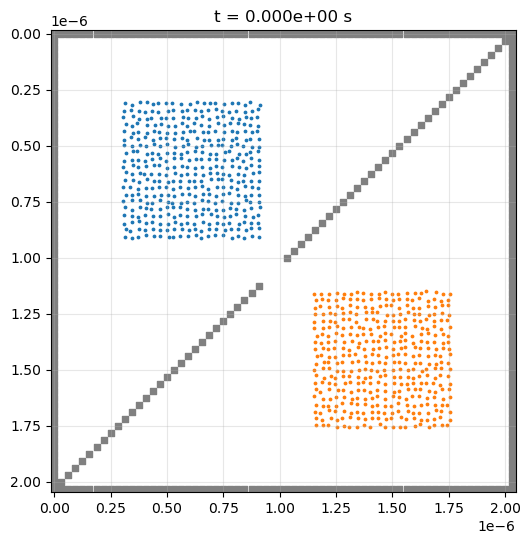

In [1738]:
a.plot(['A', 'B'])

In [1739]:
a.true_sides

array([66, 66])

In [1740]:
a.determine_maximum_timestep()

Max time step is 3.00e-03 s (max 1.0 particles in voxel)


0.002995590490797546

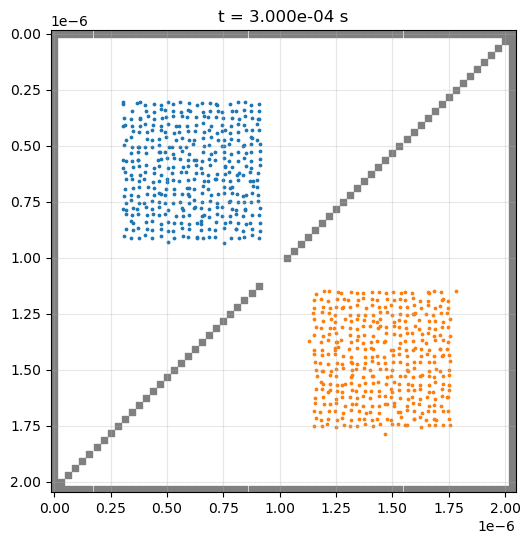

In [1741]:
a.react_diffuse(3e-4)
a.plot(['A', 'B', 'C'])

Simulate 100000 steps


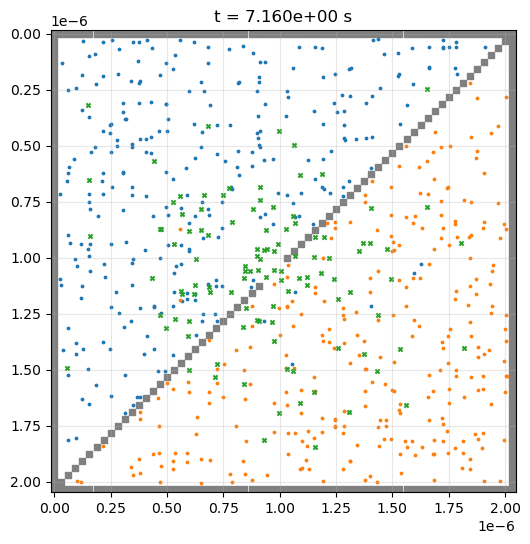

1000 2000 3000 4000 5000 

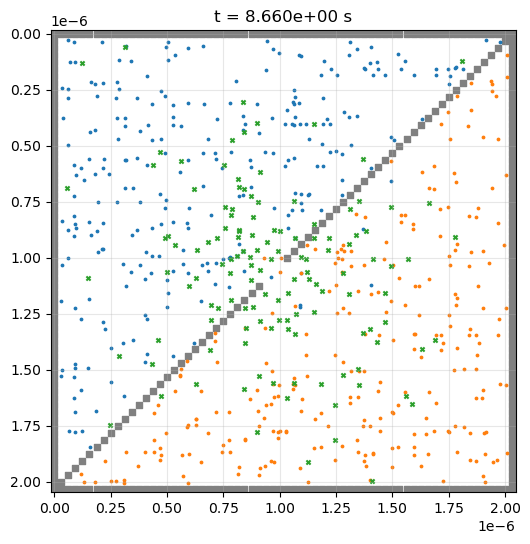

6000 7000 8000 9000 10000 9.49 s - 0.95 ms / step


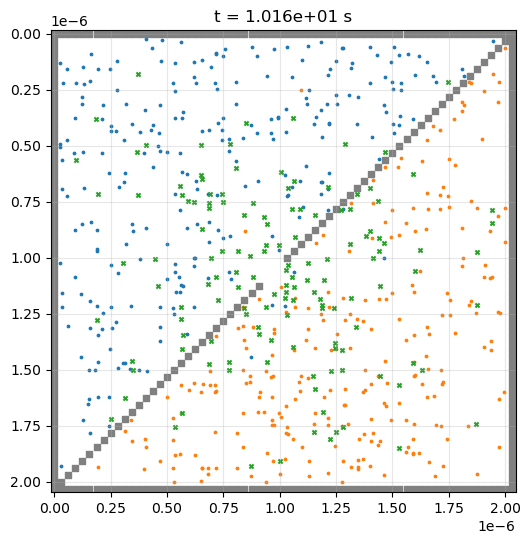

11000 12000 13000 14000 15000 

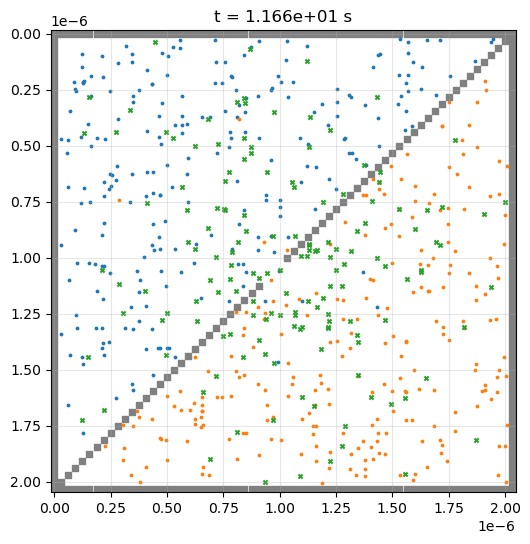

16000 17000 18000 19000 20000 19.18 s - 0.96 ms / step


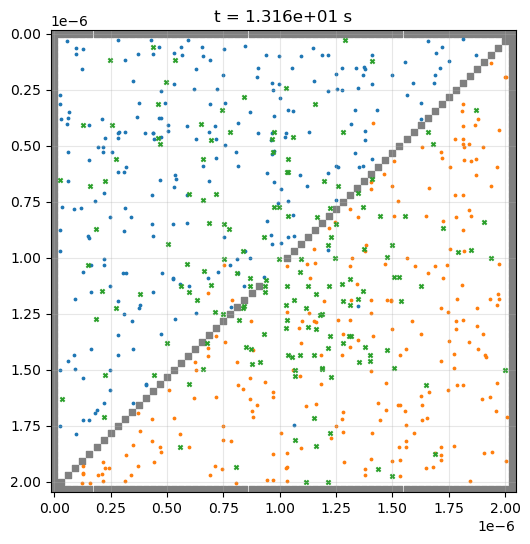

21000 22000 23000 24000 25000 

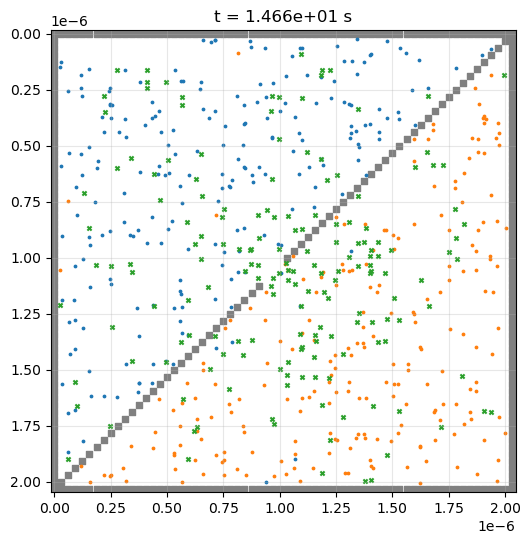

26000 27000 28000 29000 30000 28.88 s - 0.96 ms / step


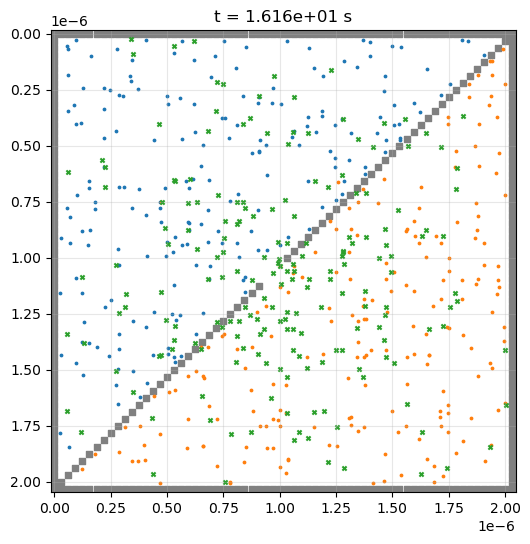

31000 32000 33000 34000 35000 

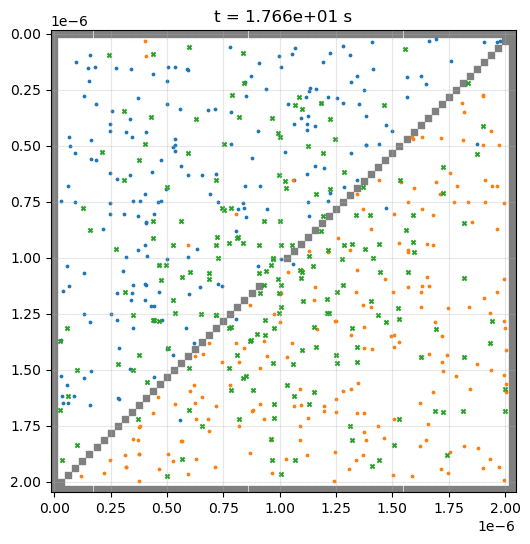

36000 37000 38000 39000 40000 38.78 s - 0.97 ms / step


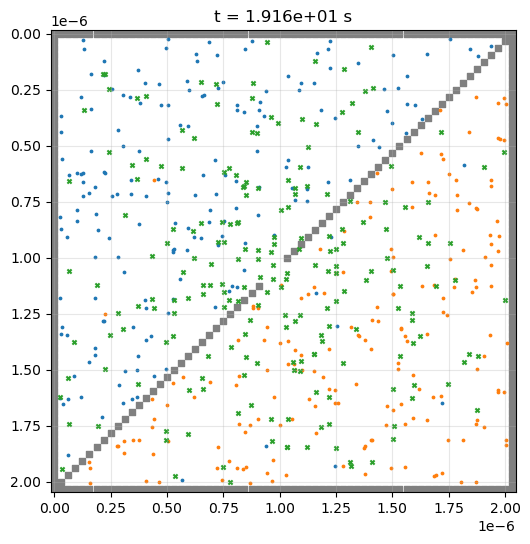

41000 42000 43000 44000 45000 

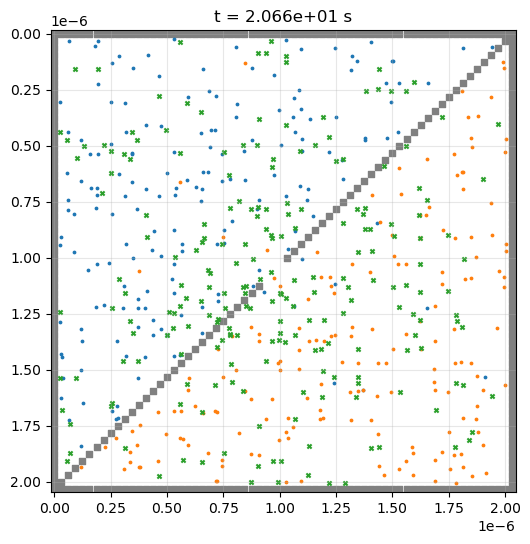

46000 47000 48000 49000 50000 48.76 s - 0.98 ms / step


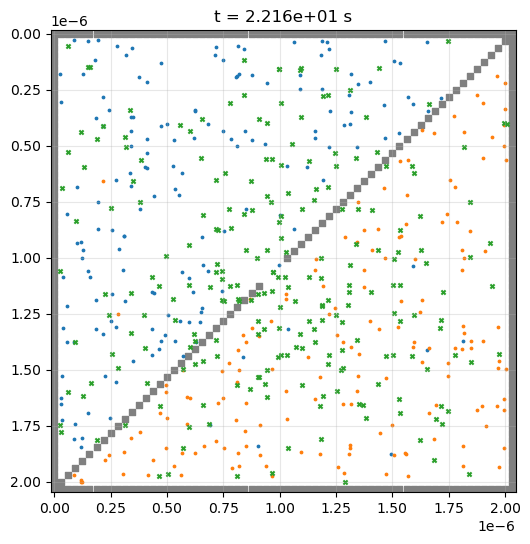

51000 52000 53000 54000 55000 

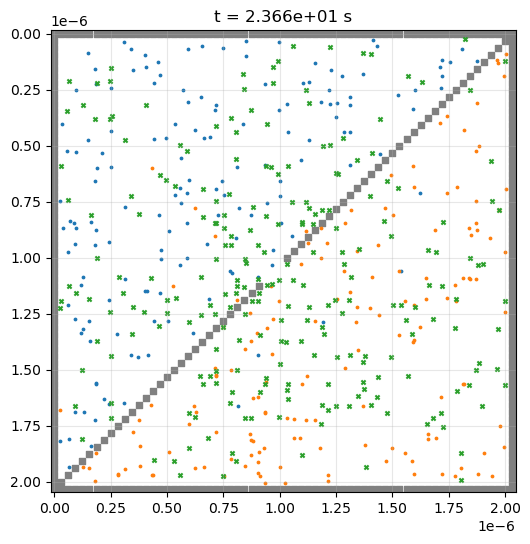

56000 57000 58000 59000 60000 58.44 s - 0.97 ms / step


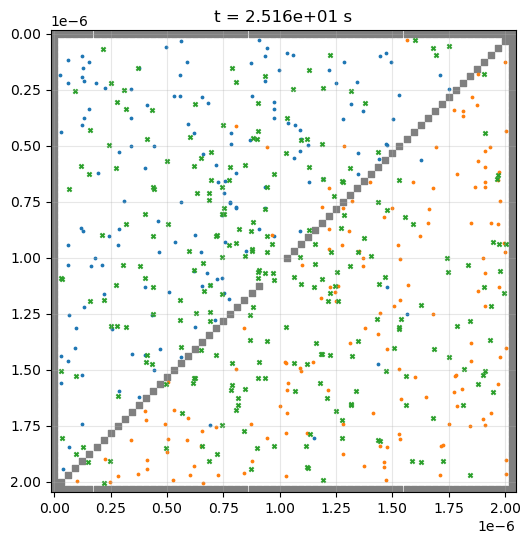

61000 62000 63000 64000 65000 

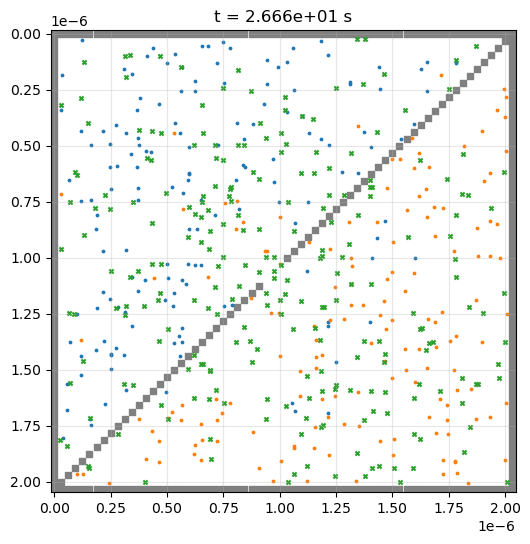

66000 67000 68000 69000 70000 68.02 s - 0.97 ms / step


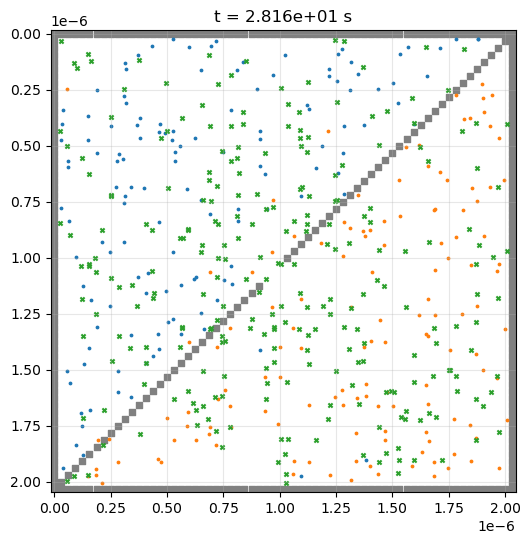

71000 72000 73000 74000 75000 

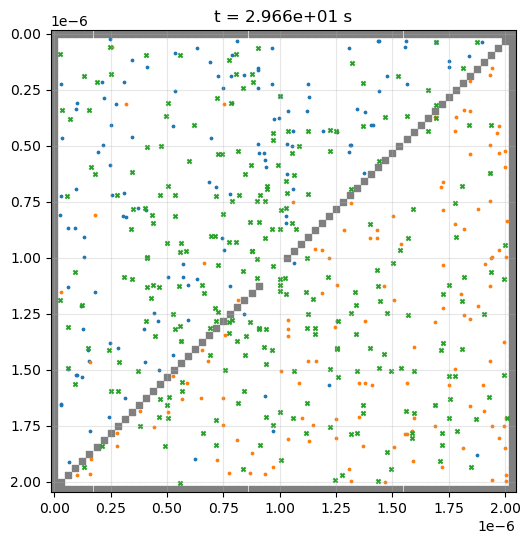

76000 77000 78000 79000 80000 77.78 s - 0.97 ms / step


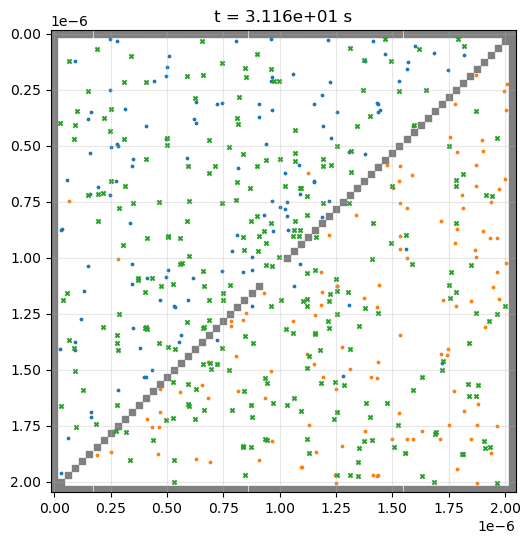

81000 82000 83000 84000 85000 

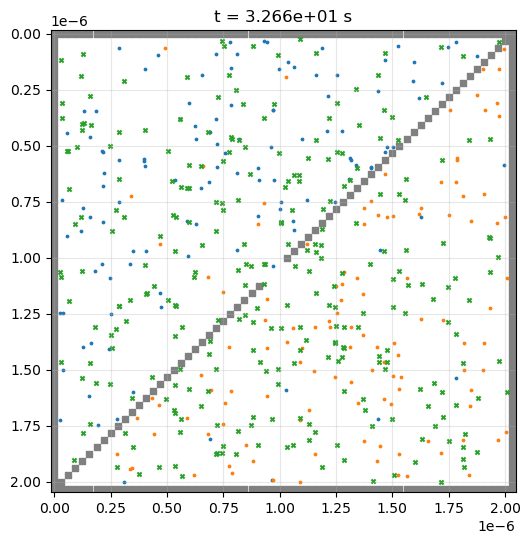

86000 87000 88000 89000 90000 87.69 s - 0.97 ms / step


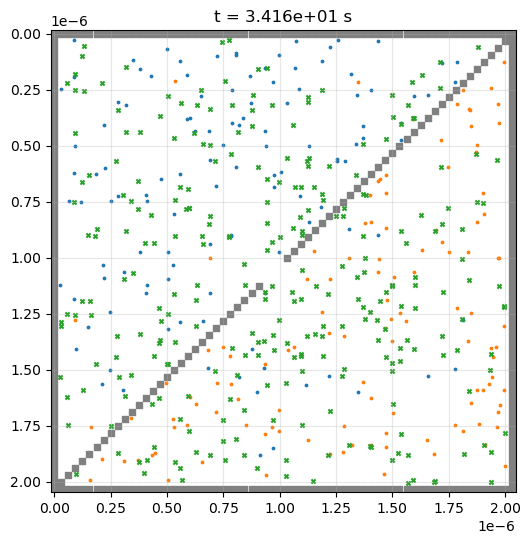

91000 92000 93000 94000 95000 

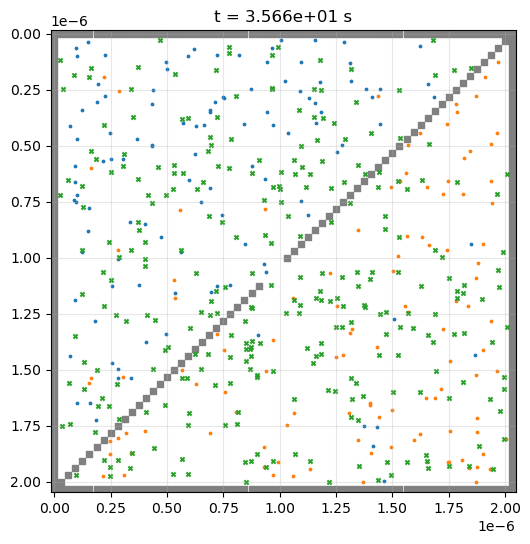

96000 97000 98000 99000 

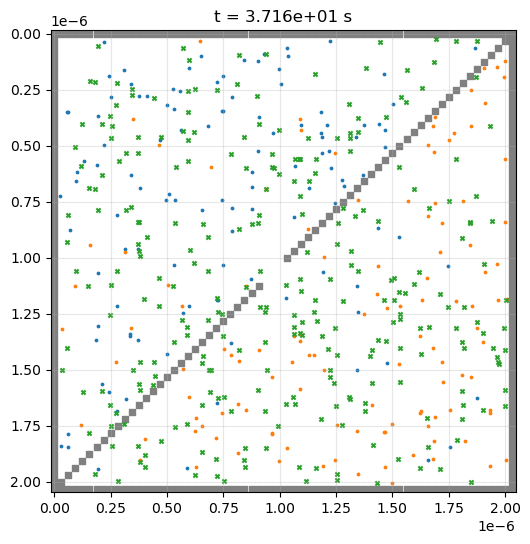

In [1743]:
a.simulate(100000, t_step=3e-4, plot_every=5000, timing=True)
a.plot(['A', 'B', 'C'])

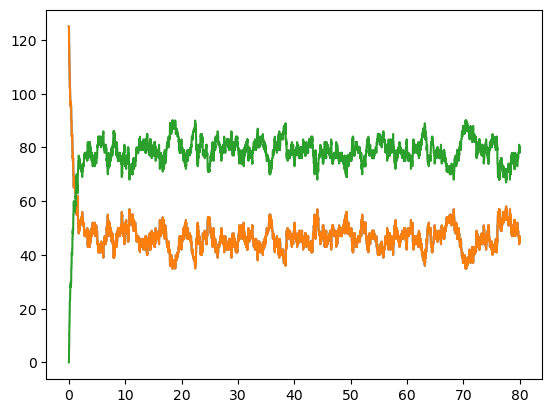

In [1638]:
plt.plot(a.t_trace, np.array(a.conc_trace))
# plt.yscale('log')

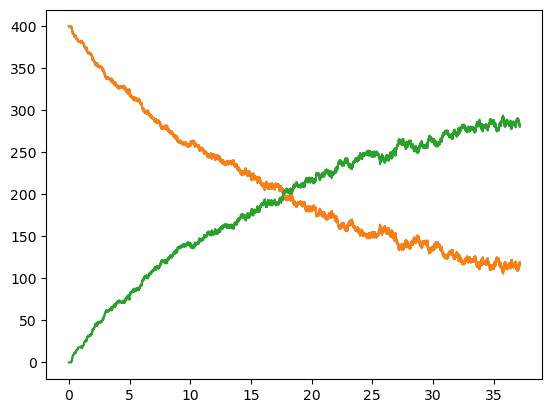

In [1744]:
plt.plot(a.t_trace, np.array(a.conc_trace))
# plt.yscale('log')